### Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

import sys
sys.path.append('../src')
from utils import TimeStepSplit, plot_classification_results

### Load Data

In [2]:
df_node = pd.read_csv('../data/processed/node_data.csv')

display(df_node)

,txId,class,timeStep,localF0,localF1,localF2,localF3,localF4,localF5,localF6,...,aggregatedF61,aggregatedF62,aggregatedF63,aggregatedF64,aggregatedF65,aggregatedF66,aggregatedF67,aggregatedF68,aggregatedF69,aggregatedF70
0,0,2,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,1,2,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,2,2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,3,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,4,2,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,203764,2,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,203765,2,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,203766,1,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,203767,2,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


### Train Test Split

In [3]:
# Split data into train and test sets
train_df = df_node[(df_node['timeStep']<=35) & (df_node['class']!=2)].reset_index(drop=True) # timeStep 1-35 (70%)
test_df = df_node[(df_node['timeStep']>35) & (df_node['class']!=2)].reset_index(drop=True) # timeStep: 36-49 (30%)

### Features

In [4]:
local_features = [col for col in df_node.columns if col.startswith('localF')]
aggregate_features = [col for col in df_node.columns if col.startswith('aggregatedF')]
all_features = local_features + aggregate_features

### Model

In [5]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample']
}

scoring = {
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'precision': 'precision',
    'recall': 'recall'
}

custom_cv = TimeStepSplit(train_df, n_splits=4)
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=custom_cv, 
                           scoring=scoring, refit='roc_auc', n_jobs=-1)

---

### Random Forest (Local Features)

In [6]:
X_train_loc = train_df[local_features]
X_test_loc = test_df[local_features]
y_train = train_df['class']
y_test = test_df['class']

- Train

In [7]:
grid_search.fit(X_train_loc, y_train)
best_estimator = grid_search.best_estimator_

print(f"Best Estimator: {best_estimator}")

results_df = pd.DataFrame(grid_search.cv_results_)
best_idx = grid_search.best_index_

print(f"Best Estimator's Cross-Validation F1: {results_df.loc[best_idx, 'mean_test_f1']:.4f}")
print(f"Best Estimator's Cross-Validation Precision: {results_df.loc[best_idx, 'mean_test_precision']:.4f}")
print(f"Best Estimator's Cross-Validation Recall: {results_df.loc[best_idx, 'mean_test_recall']:.4f}")
print(f"Best Estimator's Cross-Validation ROC AUC: {results_df.loc[best_idx, 'mean_test_roc_auc']:.4f}")

Best Estimator: RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=10, n_estimators=200, random_state=42)
Best Estimator's Cross-Validation F1: 0.8745
Best Estimator's Cross-Validation Precision: 0.9710
Best Estimator's Cross-Validation Recall: 0.8049
Best Estimator's Cross-Validation ROC AUC: 0.9776


- Test

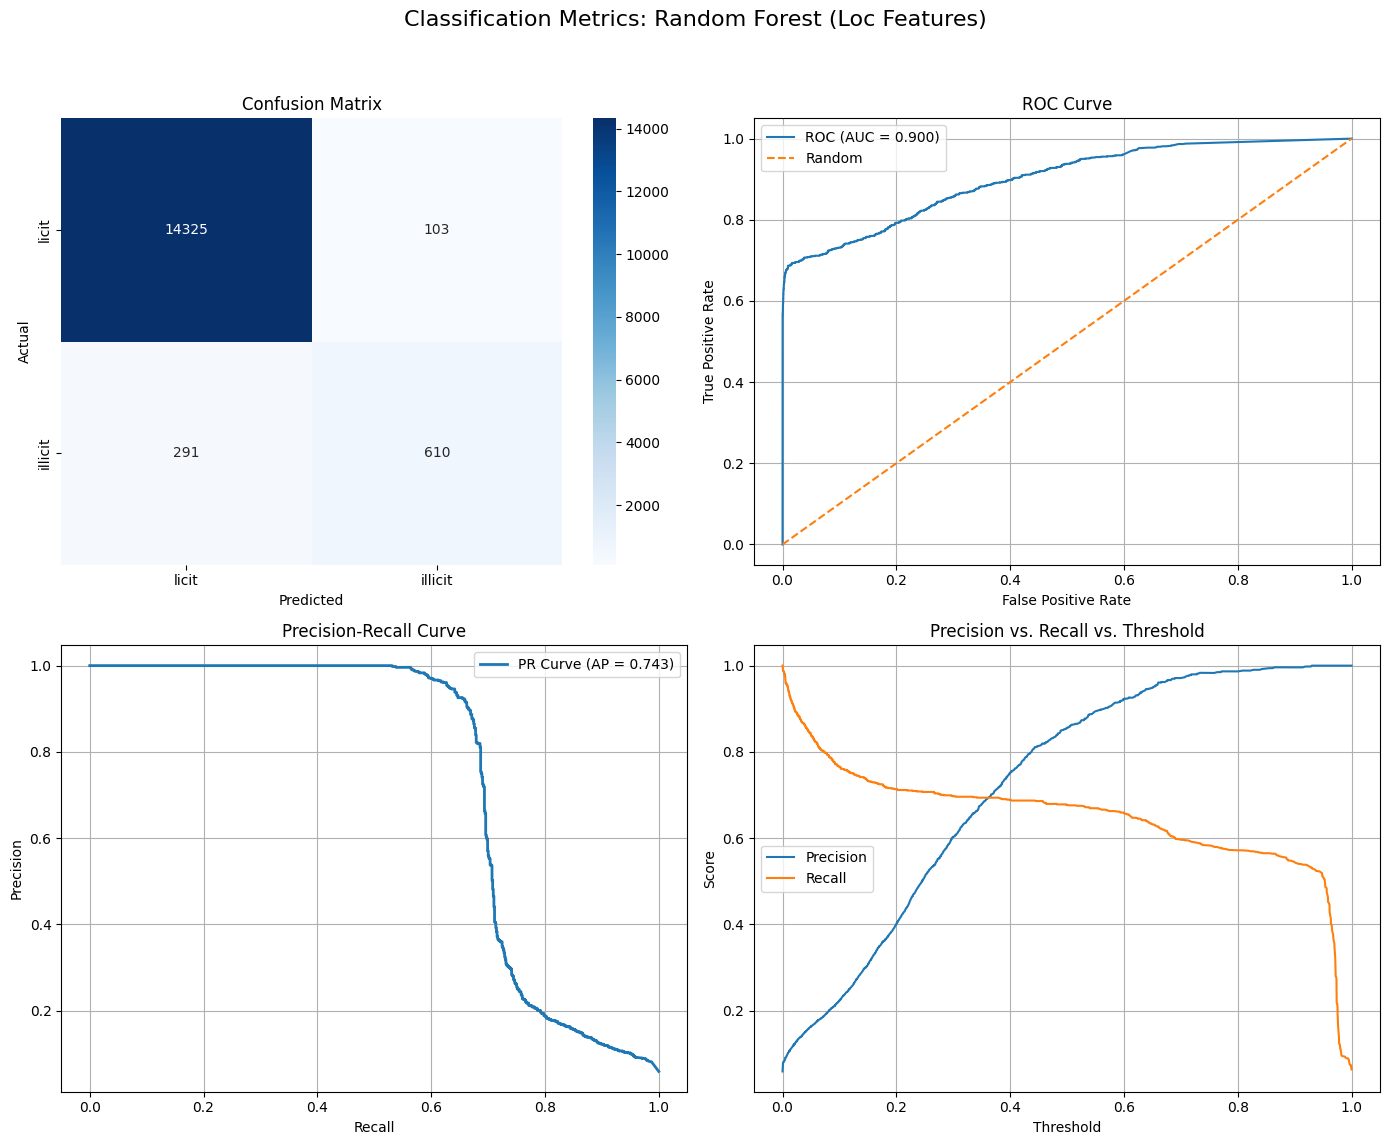

              precision    recall  f1-score   support

       licit       0.98      0.99      0.99     14428
     illicit       0.86      0.68      0.76       901

    accuracy                           0.97     15329
   macro avg       0.92      0.83      0.87     15329
weighted avg       0.97      0.97      0.97     15329

ROC AUC: 0.899589


In [8]:
y_pred = grid_search.best_estimator_.predict(X_test_loc)
y_prob = grid_search.best_estimator_.predict_proba(X_test_loc)[:, 1]

plot_classification_results(y_test, y_prob, y_pred, 'Random Forest (Loc Features)')

---


### Random Forest (Local & Aggregated Featrues)

In [9]:
X_train_all = train_df[all_features]
X_test_all = test_df[all_features]

- Train

In [10]:
grid_search.fit(X_train_all, y_train)
best_estimator = grid_search.best_estimator_

print(f"Best Estimator: {best_estimator}")

results_df = pd.DataFrame(grid_search.cv_results_)
best_idx = grid_search.best_index_

print(f"Best Estimator's Cross-Validation F1: {results_df.loc[best_idx, 'mean_test_f1']:.4f}")
print(f"Best Estimator's Cross-Validation Precision: {results_df.loc[best_idx, 'mean_test_precision']:.4f}")
print(f"Best Estimator's Cross-Validation Recall: {results_df.loc[best_idx, 'mean_test_recall']:.4f}")
print(f"Best Estimator's Cross-Validation ROC AUC: {results_df.loc[best_idx, 'mean_test_roc_auc']:.4f}")

Best Estimator: RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=10, random_state=42)
Best Estimator's Cross-Validation F1: 0.8817
Best Estimator's Cross-Validation Precision: 0.9851
Best Estimator's Cross-Validation Recall: 0.8053
Best Estimator's Cross-Validation ROC AUC: 0.9793


- Test

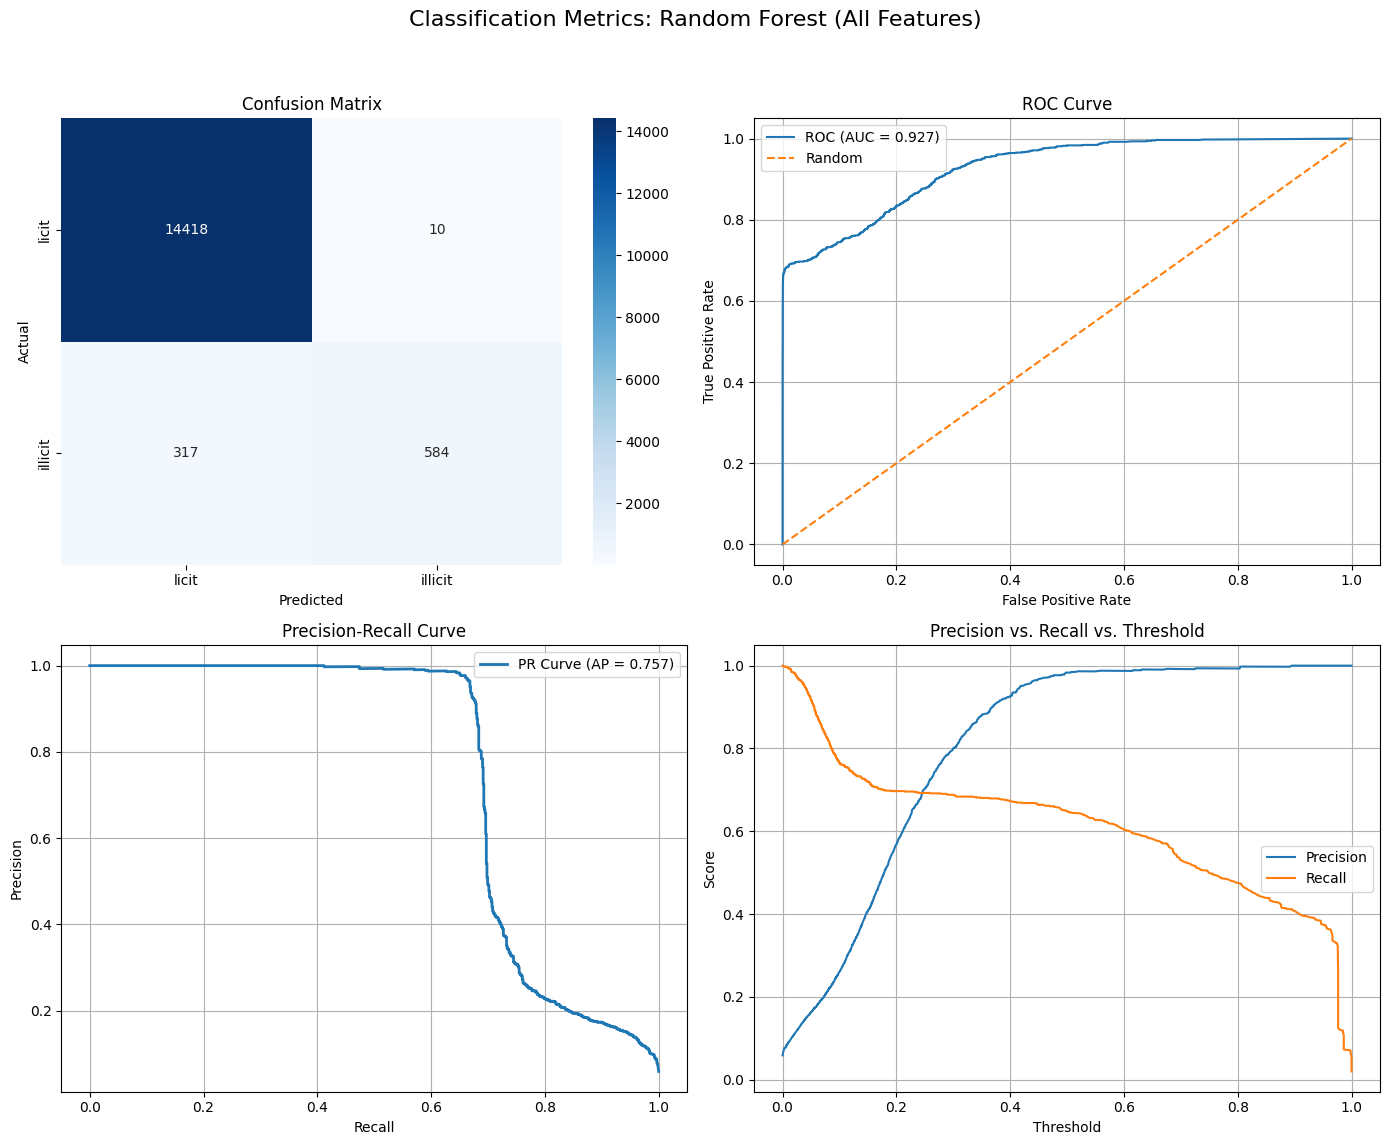

              precision    recall  f1-score   support

       licit       0.98      1.00      0.99     14428
     illicit       0.98      0.65      0.78       901

    accuracy                           0.98     15329
   macro avg       0.98      0.82      0.89     15329
weighted avg       0.98      0.98      0.98     15329

ROC AUC: 0.926911


In [11]:
y_pred = grid_search.best_estimator_.predict(X_test_all)
y_prob = grid_search.best_estimator_.predict_proba(X_test_all)[:, 1]

plot_classification_results(y_test, y_prob, y_pred, 'Random Forest (All Features)')